## Here comes the problem.

If we had word vectors with 300 components, and a vocabulary of 10000 words. The neural network had 2 weight matrices - a hidden layer and an output layer. Both these layers would have a weight matrix with $300 \times 10000 = 3 million$ weights each.

Running gradient descent on a neural network that large is going to be slow. And matter worse, need a huge amount of training data in order to tune that many weights and avoid over-fitting.

## How to address the problem

1. Treating common word pairs or phrases as single "words"

2. Subsampling frequent words to decrease the number of training examples.

3. Modifying the optimization objective with a technique called "Nagative Sampling", which causes each training sample to update only a small percentage of the model's weights.

## Word Pairs and "Phrases"

A word pair like "Boston Globe" has a much different meaning than the individual words "Boston" and "Globe". So it makes sense to treat "Boston Globe" wherever it occurs in the text, as a single word with its own word vector representation.

## Subsampling Frequent Words

The picture below showed how training samples were created from the source text.

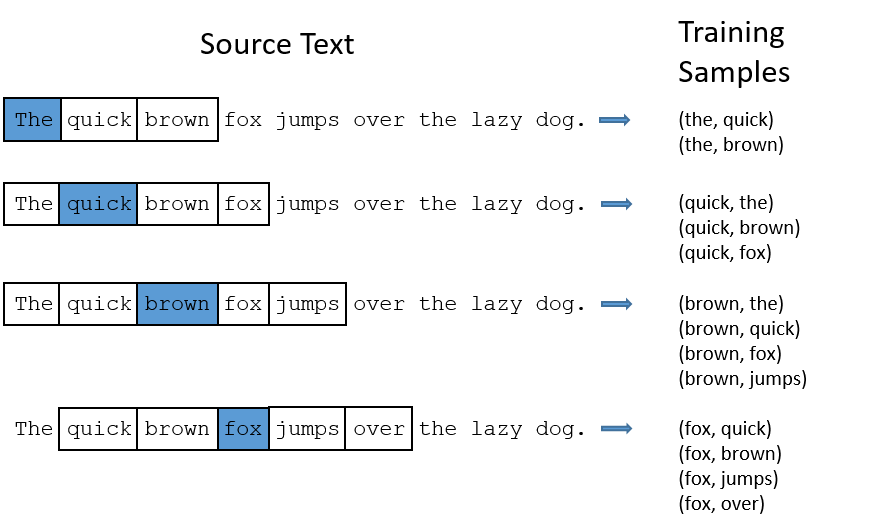

There are two "problems" with common word like "the":

1. When looking at word pairs, ("fox", "the") doesn't tell use much about the meaning of "fox", "the" appears in the context of pretty much every word.

2. We will have many more samples of ("the", ...) than we need to learn a good vector for "the".

**Word2Vec implements a "subsampling" scheme to address this problem. For each word we encounter in training text, there is a chance that we will effectively delete it from the text. The probability that we cut the word is related to the word's frequency.
**

If we have a window size of 10, and we remove a specific instance of "the" from the text:

1. As we train on the remaining words, "the" will not appear in any of their context windows.

2. We'll have 10 fewer training samples where "the" is the input word.

## Sampling rate

* $w_i$ is the word. 
* $z(w_i)$ is the fraction of the total words in the corpus that are that word. 

* There is also a parameter named "sample" which controls how much subsampling occurs, and default value is 0.001. Smaller values of "sample" mean words are less likely to be kept.

$P(w_i)$ is the probability of keeping the word:

$$
P(w_i) = (\sqrt \frac{z(w_i)}{sample} + 1) \times \frac{sample}{z(w_i)}
$$

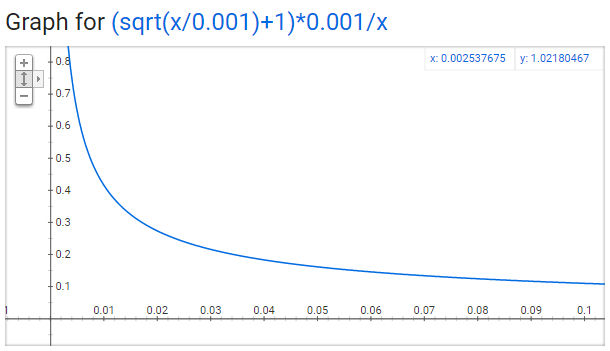

**No single word should be a very large percentage of the corpus.**

Here are some intersting points in this function(again this is using the default sample value of 0.001)

* $P(w_i) = 1.0$ (100% chance of being kept) when $z(w_i) \le 0.0026$ This means that only words which represent more than $0.26%$ of the total words will be subsampled.

* $P(w_i) = 0.5$ (50% chance of being kept) when $z(w_i) = 0.00746$.

* $P(w_i) = 0.033$ (3.3% chance of being kept) when $z(w_i) = 1.0$
    * That is, if the corpus consisted entirely of word $w_i$, which of course is ridiculous.

## Negative Sampling

Each training sample will tweak all of the weights in the neural network. Any update we do or evaluation of the objective function would take $O(|V|)$ time which if we recall is in the millions.

**Negative sampling addresses this update all weights issue by having each training sample only modify a small percentage of the weights, rather than all of them.**

When training the network on the word paris("fox", "quick"), recall that the "lable" or "correct output" of the network is a one-hot vector. That is , for the output neuron corresponding to "quick" to output a 1, and for all of other thousands of output neurons to output a 0.

**With negative sampling, we are instead going to randomly select just a small number of "negative" words (let's say 5） to update the weights for. (In this context, a "negative" word is one for which we want the network to output a 0 for), We will also still update the weights for "positive" word.**

Recall that the output layer of the model has a weight matrix that is $300 \times 10000$ entries. We will just be updating the weights for our positive word ("quick"), plus the weights for 5 other words that we want to output 0. That's a total of 6 output neurons, and 1800 weight values total, only $0.06%$ of the 3M weights in the output layer.

In the hidden layer, only the weights for the input word are updated.

## Selecting Negative Samples


Consider a pair $(w, c)$ of word and context. Denote by P(D = 1|w, c) the probability that (w, c) came from the corpus data, correspondingly, $P(D=0|w,c)$ will be the probability that $(w,c)$ did not come from the corpus data.

First, let's model $P(D=1|w,c)$ with the sigmoid function:

$$
P(D=1|w,c,\theta) = \sigma(v_c^Tv_w) = \frac{1}{1+e^(-v_c^Tv_w)}
$$

No we can build a new objective function that tries to maximize the probability of a word and context being in the corpus data if it indeed is, and maximize the probability of a word and context not being in the corpus data if it indeed is not.

Take a maximum-likelihood estimation to these two probabilites, take $\theta$ to be the parameters of the model.

$$
\begin {eqnarray}
\theta & = & argmax_\theta\Pi_{(w,c)\in D}P(D=1|w,c,\theta) \Pi_{(w,c)\notin D}P(D=0|w, c, \theta)\\
& = & argmax_\theta\Pi_{(w,c) \in D}P(D=1|w,c,\theta) \Pi_{(w,c)\notin D}(1 - P(D=1|w, c, \theta))\\
& = & argmax_\theta\Sigma_{(w,c)\in D}\log P(D=1|w,c,\theta) + \Sigma_{(w,c)\notin D}\log(1 - P(D=1|w,c,\theta))\\
& = & argmax_\theta\Sigma_{(w,c)\in D}\log\frac{1}{1+\exp(-u_w^Tv_c)} + \Sigma_{(w,c)\notin D}\log(1-\frac{1}{1+\exp(-u_w^Tv_c)})\\
& = & argmax_\theta\Sigma_{(w,c)\in D}\log\frac{1}{1+\exp(-u_w^Tv_c)} + \Sigma_{(w,c)\notin D}\log\frac{1}{1+\exp(u_w^Tv_c)}
\end{eqnarray}
$$

Note that maximizing the likelihood is the same as minimizing the negative log likelihood.

$$
J = -\Sigma_{(w,c)\in D}\log\frac{1}{1+\exp(-u_w^Tv_c)} - \Sigma_{(w,c)\notin D}\log(\frac{1}{1+\exp})
$$

**For skip-gram, new objective function for observing the context word $c-m+j$ given the center word $c$ would be**

$$
-\log\sigma(u_{c-m+j}^Tv_c) - \Sigma_{k=1}^K\log\sigma(-\tilde{u}_k^Tv_c)
$$

**For CBOW, new objective function for observing the center word $u_c$ given the context vector $\hat{v} = \frac{v_{c-m} + v_{c-m+1} + ... + v_{c+m}}{2m}$ would be**

$$
-\log\sigma(u_v^T\hat{v}) - \Sigma_{k=1}^K\log\sigma(-\tilde{u}_k^T\hat{v})
$$

In the above formulations, $\{\tilde{u}_k|k=1...K\}$ are sampled from $P_n(w)$.

So what $P_n(w)$ should be, is which could make the best approximation.

The "negative samples" (that is, the 5 output words that we'll train to output 0) are chosen using a **"unigram distribution"**.

** The probability for selecting a word as a negative sample is related to its frequency, with more frequent words being more likely to be selected as negative samples.**

Each word is given a weight equal to it's frequency(word count) raised to the $3/4$ power. The probability for selecting a word is just it's weight divided by the sum of weights for all words.
$$
P(w_i) = \frac{f(w_i)^{3/4}}{\Sigma_{j=0}^nf(w_j)^{3/4}}
$$

The decision to raise the frequency to the $3/4$ power appears to be empirical, In the related papar, it's said outperformed other functions.